# Spectrum calculation

This section focus on the calculation of XPS, XAS, XES, and RIXS, with focus on considering these spectroscopies with ADC and (TD)DFT. For a more general overview of the large number of methods available for considering these properties, see, *e.g.*, {cite}`xrayrev2018`.

```{note}
No multi-reference methods, at the moment.
```

*Loading modules and functions:*

In [1]:
# standard Python modules and functions
from scipy.interpolate import interp1d
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import copy

# QC software suites and functionalities
from pyscf import gto, scf, mp, cc
import veloxchem as vlx
import gator
import adcc
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI
comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386

/home/thomas/Notebook/anaconda/envs/echem/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Status size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Datatype size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Request size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Prequest size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Grequest 

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


(sec:xray_calc_xps)=
## X-ray photoemission spectroscopy

In XPS the photoemission of electrons is measured, yielding information on core-electron binding energies. Here we focus on the calculation of ionization energies (IE:s), from which the isotropic photoemission spectrum is formed by giving each IE the same intensity and then broadening with an appropriate convolution function. It is possible to go beyond such a simple approach using Dyson orbitals, but it typically does not make much of a difference {cite}`ccsdDyson2019`. 

### IE:s from Koopmans' theorem

A simple model for calculating ionization energies and electron affinities is from Koopmans' theorem, where they are estimated from the MO energies. For water, we obtain a 1s IE of:

In [2]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create veloxchem mol and basis objects
mol_vlx = vlx.Molecule.read_str(water_xyz) 
bas_vlx = vlx.MolecularBasis.read(mol_vlx, '6-31G') 

# Perform SCF calculation
scf_gs = vlx.ScfRestrictedDriver(comm, ostream=silent_ostream)
scf_gs.compute(mol_vlx, bas_vlx)

# Extract orbital energies
orbital_energies = scf_gs.scf_tensors['E']
print('1s E from the Koopmans theorem:',np.around(au2ev*orbital_energies[0],2))

1s E from the Koopmans theorem: -559.5


This can be compared to the experimental value, which is 539.9 eV. The overestimation of almost 20 eV is due to lack of [relaxation](sec:xray_topics_relax), which results from the reorganization of the valence electrons in response to a reduction in screening of the nuclei. By comparison, in valence spectroscopies the change in shielding is significantly smaller, yielding a far smaller error due to the lack of relaxation for, e.g., calculation of HOMO IE:s or LUMO EA:s.

An approach for including relaxation effects IE calculations is to instead use the $\Delta\textrm{SCF}$ approach, in which the difference in total energy between the neutral and a core-hole system yields estimates of core-electron binding energies.


### The maximum overlap method

In order to converge a core-hole state, an approach which avoid the convergence to a lower-energy valence-hole state is needed. This can be done using several approaches, but the focus here will be on the maximum overlap method (MOM), with which a SCF optimization with the constraint of maximizing the overlap to some initial guess {cite}`mom1971, maxover2008`. The guess is typically taken as the converged wave function of the neutral (no core-hole) system, and new occupied orbitals at each iteration is taken such that they overlap most with the span of old occupied orbitals. Defining the overlap matrix as

$$
\textbf{O} = 
\left( \textbf{C}^{\textrm{old}} \right)^{\dagger} \textbf{SC}^{\textrm{new}},
$$

with $O_{ij}$ being the overlap between the $i$:th old and $j$:th new orbital, and $\textbf{C}$ and $\textbf{S}$ are the MO coefficient matrices and basis function overlap matrix, respectively. The projections of $j$:th new orbital onto the old space is then

$$
p_j = \sum_i^n O_{ij} = 
\sum_a^N (
\sum_b^N (
\sum_i^n C_{ib}^{old} )
S_{bc} )
C_{cj}^{old}.
$$

The occupied orbitals are then selected by largest $p_j$ values.

With this, a converged core-hole wave function is obtained with the following scheme:

1. Calculate the wave-function of the original system (*e.g.* no core-hole).

2. Use above wave-function as a starting guess for a new wave function optimization, removing an electron from desired orbital (and potentially occupying some other virtual orbital).

3. Optimizing this state using the MOM restriction.

This can then converge many unstable states, including core-ionized states and certain core-excited states. Some care should observed, though:

- If excited states are considered, check that the final state is reasonable close to what is investigated.

- [Delocalized core orbitals](sec:xray_topics_chloc) need to be localized, for example by employing ECP:s.

- If post-HF methods are used, the ground state calculation can attempt to (partially) fill the core-hole of the [non-*Aufbau* reference state](sec:xray_topics_nonaufbau), leading to a corrupt wave function which represents some intermediate between a core-hole/valence-hole state.

```{note}
We currently use `pyscf` for the calculations involving explicit core-holes, as `veloxchem` presently lacks MOM.
```

### IE:s from $\Delta\textrm{SCF}$

The IE of water using $\Delta\textrm{SCF}$ is then computed as:

In [3]:
# Create pyscf mol object
mol = gto.Mole()
mol.atom = water_xyz
mol.basis = '6-31G'
mol.build()

# Perform unrestricted SCF calculation
scf_gs = scf.UHF(mol)
scf_gs.kernel()

# Copy molecular orbitals
mo0 = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)

# Create 1s core-hole by setting alpha_0 population to zero
occ0[0][0] = 0.0
    
# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# IE from energy difference
print('Ionization energy:',np.around(au2ev*(scf_ion.energy_tot() - scf_gs.energy_tot()),2),'eV')

converged SCF energy = -75.9838703827192  <S^2> = 6.3389294e-12  2S+1 = 1


Overwritten attributes  get_occ  of <class 'pyscf.scf.uhf.UHF'>


converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387
Ionization energy: 541.73 eV


This estimate is within 2 eV from experiment, and we can include electron correlation using MP2:

In [4]:
# Run MP2 on neutral and core-hole wave functions
mp_res = mp.MP2(scf_gs).run()
mp_ion = mp.MP2(scf_ion).run()

# IE from energy difference
print('Ionization potential:',np.around(au2ev*(mp_ion.e_tot - mp_res.e_tot),2),'eV')

E(UMP2) = -76.1130483955489  E_corr = -0.1291780128297
E(UMP2) = -56.1523709631034  E_corr = -0.0768920160169647
Ionization potential: 543.16 eV


Alternatively, we can consider this with KS-DFT:

In [5]:
# Perform unrestricted SCF calculation with a B3LYP
scf_gs = scf.UKS(mol)
scf_gs.xc = 'b3lyp'
scf_gs.kernel()

# Copy molecular orbitals
mo0 = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)

# Create 1s core-hole by setting alpha_0 population to zero
occ0[0][0] = 0.0
    
# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UKS(mol)
scf_ion.xc = 'b3lyp'
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# IE from energy difference
print('Ionization energy:',np.around(au2ev*(scf_ion.energy_tot() - scf_gs.energy_tot()),2),'eV')

converged SCF energy = -76.3480474320839  <S^2> = 2.5501379e-11  2S+1 = 1


Overwritten attributes  get_occ  of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -56.4125421194361  <S^2> = 0.75441021  2S+1 = 2.0044054
Ionization energy: 542.47 eV


MP2 and DFT currently brings us *away* from experiment when comparing to HF, but we note that the basis set is small and ill-suited for core properties. Using a cc-pCVTZ basis we obtain:
- HF: 538.93 eV
- MP2: 540.26 eV
- B3LYP: 539.19 eV

So closer to experiment for the correlated methods (note that scalar-relativistic effects will shift these results upwards by $\sim$0.37 eV).

### Spectra from $\Delta\textrm{SCF}$

The X-ray photoemission spectrum can be formed by computing all relavant core-electron binding energies (or IE:s), give each unique ionization equal intensity, and broaden over the result with an appropriate convolution function.

We here consider ethyl trifluoroacetate( (CF$_3$-CO-O-CH$_2$-CH$_3$), also known as the ['ESCA' molecule](https://doi.org/10.1016/j.elspec.2012.05.009), which possess very illustrative shifts in XPS features (IE:s) of the carbon $K$-edge due to interactions with the very electronegative oxygen and fluorine atoms. We calculate the four carbon 1s IE:s with $\Delta\textrm{SCF}$:

```python
esca_xyz   = '''
C         1.1183780041   -0.3449927563    0.0140172822
C         0.2599020293    0.9430366372   -0.0248385056
F         2.4019839124   -0.0408200726   -0.0368443870
F         0.8399255955   -1.1560630574   -1.0169777359
F         0.8945563482   -1.0267696528    1.1485539196
O         0.7954196415    2.0187110930    0.0011424145
O        -1.0675509573    0.8144007049   -0.0614767265
C        -1.7486063992   -0.4602333713   -0.1739210991
C        -3.1986940727   -0.1850294900    0.1302033614
H        -1.3268717284   -1.1720377773    0.5289059043
H        -1.6185520565   -0.8344576449   -1.1859838788
H        -3.3116641442    0.1959612359    1.1419001202
H        -3.7716619472   -1.1057672384    0.0380096706
H        -3.6012985602    0.5468300237   -0.5651778685            
'''

# Create pyscf mol object
mol = gto.Mole()
mol.atom = esca_xyz
mol.basis = '6-31G'
mol.build()

# Perform unrestricted SCF calculation
scf_gs = scf.UHF(mol)
scf_gs.kernel()

# Perform core-hole calculation for each carbon atom (MOs 5-8) and append resulting IE:s to a list
esca_ies = []
for n in [5,6,7,8]:
    # Copy molecular orbitals
    mo0  = copy.deepcopy(scf_gs.mo_coeff)
    occ0 = copy.deepcopy(scf_gs.mo_occ)
    # Create 1s core-hole by setting alpha_n population to zero
    occ0[0][n] = 0.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    esca_ies.append(au2ev*(scf_ion.energy_tot() - scf_gs.energy_tot()))
```

The choice of convolution function depends on the dominant broadening effect (lifetime of excited/ionized state, experimental resolution, Doppler effect, ...). We generally focus on Lorentzian broadening, which is the type which naturally comes out of damped response calculations and which relates to the finite life-time of the excited/ionized state. 

```{note}
Move broadening discussion to UV/vis and link to this.
```

Giving each ionization energy equal weight, Lorentzian and Gaussian broadening are performed as below, for which the full-width at half-max (FWHM) is equal to $\gamma $ and $ 2\sqrt{2\ln{2}} \sigma$, respectively. If better correspondence to experiment is sought, a Voigt profile can be constructed from the convolution of a Lorentzian and a Gaussian.

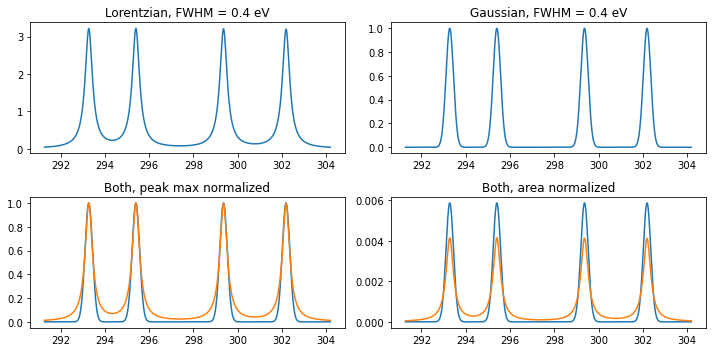

In [11]:
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    '''
    Lorentzian broadening function
    
    Call: xi,yi = lorentzian(energies, intensities, start energy, end energy, energy step, gamma)
    '''
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = yi[i] + y[k] * gamma / ( (xi[i]-x[k])**2 + (gamma/2.)**2 ) / np.pi
    return xi,yi

def gaussian(x, y, xmin, xmax, xstep, sigma):
    '''
    Gaussian broadening function
    
    Call: xi,yi = gaussian(energies, intensities, start energy, end energy, energy step, gamma)
    '''
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)): 
        for k in range(len(y)): yi[i] = yi[i] + y[k]*np.e**(-((xi[i]-x[k])**2)/(2*sigma**2))
    return xi,yi

# IEP:s from above calculation
esca_ies = [302.187, 299.362, 295.405, 293.277]

plt.figure(figsize=(10,5))
plt.subplot(221); plt.title('Lorentzian, FWHM = 0.4 eV')
x,y = esca_ies,np.ones((len(esca_ies)))
xi,yi = lorentzian(x,y,min(x)-2,max(x)+2,0.01,0.4); plt.plot(xi,yi)

plt.subplot(222); plt.title('Gaussian, FWHM = 0.4 eV')
xi,yi = gaussian(x,y,min(x)-2,max(x)+2,0.01,0.4/(2*np.sqrt(2*np.log(2)))); plt.plot(xi,yi)

plt.subplot(223); plt.title('Both, peak max normalized')
xi,yi = gaussian(x,y,min(x)-2,max(x)+2,0.01,0.4/(2*np.sqrt(2*np.log(2)))); plt.plot(xi,yi/max(yi))
xi,yi = lorentzian(x,y,min(x)-2,max(x)+2,0.01,0.4); plt.plot(xi,yi/max(yi))

plt.subplot(224); plt.title('Both, area normalized')
xi,yi = gaussian(x,y,min(x)-2,max(x)+2,0.01,0.4/(2*np.sqrt(2*np.log(2)))); plt.plot(xi,yi/sum(yi))
xi,yi = lorentzian(x,y,min(x)-2,max(x)+2,0.01,0.4); plt.plot(xi,yi/sum(yi))
plt.tight_layout(); plt.show()

For the comparison to [experiment](https://doi.org/10.1016/j.elspec.2012.05.009) a cc-pVTZ basis set is selected, augmented with additional core-polarizing functions for the carbon atoms (i.e. cc-pCVTZ):

```{figure} ../img/xray/esca_xps.svg
---
name: esca_xps
---
Carbon 1s XPS of ESCA, comparing $\Delta\textrm{SCF}$ results to experiment. Theoretical spectrum shifted by 0.11 eV (to account for relativistic effects) and broadened by 0.3 eV.
```

The features originate in, from low to high energy: -CH$_3$, -CH$_2$-, -CO-, and CF$_3$. We note a good agreement for the first two features, but the comparison deteriorates for higher energies. This is largely an effect of the more significant change in electronic structure imposed by the very electronegative fluorine and oxygen atoms, which the current level of theory is not capable of describing as well.

### Other approaches

Alternative methods of considering XPS and IE:s include, among others:

- IP-ADC

- IP-CC

- ...



(sec:xray_calc_xas)=
## X-ray absorption spectroscopy

In XAS the energy-dependent photoabsorption of the sample is measured, probing excitation of core electrons to bound or continuum states. These two different final states then provide information on unoccupied states and local chemical environment, respectively, with a prototypical spectrum of a conjugated system: 


```{figure} ../img/xray/xafs.svg
---
name: xafs
---
Prototypical X-ray absorption spectrum of a conjugated system.
```

Above the spectrum we see two disctinct regions with different features and physical origins:

- **NEXAFS (near-edge X-ray absorption fine structure:** the region in which transitions to bound states is probed (this region is also known as XANES, X-ray absorption near-edge structure).

- **EXAFS (extended X-ray absorption fine structure):** which consists of transitions to continuum states, as modulated by constructive or destructive interference between the emitted electron and the environment. This thus provide information on local chemical bonds.

Included is also the position of the IE, as well assignment of typical features ($\pi^*$, Rydberg, and $\sigma^*$). Transitions to $\pi^*$ states are typically low in energy and very intense, and thus easy to identify. Rydberg states are typically weak and converge to the ionization energy. Finally, transitions to $\sigma^*$ states can be found above the ionization energy.

The total spectrum is referred to as the **XAFS (X-ray absorption fine structure)** region. For the remainder of this tutorial we will focus on NEXAFS, for which good starting points for modeling with ADC and TDDFT can be found in {cite}`cvsadc32015, coretddft2010, xrayrev2018`.


(sec:xray_calc_cvs)=
### Decoupling from the valence continuum

A complication that arise when considering core excitations is the embedding of the core-excited states into the continuum of valence-ionized states. This means that the targetted core-excited states cannot easily be resolved with, *e.g.*, a Davidson approach, as a large number of valence-excited/-ionized states need to be converged first. A number of approaches have been developed to remove this issue, including:

- The core-valence separation (CVS) approximation {cite}`cederbaum1980, cvsadc32015, cvseomccsd2019`

- Restricted energy window (which is largely a different flavour of CVS) {cite}`rttddft2012`

- Using the complex polarization propagator (CPP), where the response at arbitrary frequencies is directly probed {cite}`cppdft1`

- Real-time propagation of the electronic structure {cite}`rttddft2012`

- Methods which construct explicit excited states

```{note}
Within a damped response framework and using real-time propagation there can be spurious mixing with valene-ionized states, which will results in unphysical mixing to a discretized continuum. This is briefly dfiscussed [here](sec:xray_cons_spur_val).
```


The focus in this tutorial is the use of the CVS approximation and the CPP approach, with which interior eigenstates and response at arbitrary frequencies can be address, as illustrated in {numref}`global_xray`:


```{figure} ../img/xray/cvs_adc.svg
---
name: global_xray
---
Global spectrum of water, using the 6-311G basis set. Results obtained with ADC(1), CVS-ADC(1), ADC(2), CVS-ADC(2), and CPP-DFT. CPP-DFT results obtained using the B3LYP exchange-correlation functional and a large $\gamma$ of 1 eV. ADC results shown as bar spectra.
```

Here we see the global spectrum of water, using a rather limited basis set. Even so, ADC(1) requires more than 50 states to resolved the core-excitation region (situated at about 535 eV for water), and for ADC(2) 50 states brings us only to about 50 eV. With the CVS approximation we directly target the core-excitation region, but it should be noted that this also introduces a small error. However, this error has been shown to be relatively small (provided a reasonable basis set) and stable for AD {cite}`Herbst2020`, and for TDHF and TDDFT it is all but negligible. Using CPP-DFT, this error is avoided all together (although CPP-ADC has been noted to be hard to converge for core-excited state {cite}`gator`, so here CVS-CPP-ADC might instead be used - thus including this small error).


### Spectra from CVS-ADC eigenstates

With CVS-ADC, the core-excitation spectra are calculate by specifying the index of the probed core orbitals(s):

In [12]:
# Construct structure and basis objects
struct = gator.get_molecule(water_xyz)
basis = gator.get_molecular_basis(struct, '6-31G')

# Perform SCF calculation
scf_gs = gator.run_scf(struct,basis)

# Calculate the 6 lowest eigenstates with CVS restriction to MO #1 (oxygen 1s)
adc_res = gator.run_adc(struct, basis, scf_gs, method='cvs-adc2x', singlets=4, core_orbitals=1)

* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.9/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
         

SCF converged in 4 iterations.
Total Energy: -75.9838703827 au
Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.2621  196ms  [20.27035914 20.30081846 20.86977788 20.91121543]
  2    16      0.038976  389ms  [19.72495603 19.8069198  20.5088101  20.51570002]
  3    24     0.0035541  594ms  [19.71673659 19.79707775 20.49577451 20.50503439]
  4    32    0.00029894  532ms  [19.71639076 19.79671173 20.49373735 20.50484025]
  5    40    3.1991e-05  423ms  [19.71637587 19.79669994 20.49353419 20.50482669]
=== Restart ===
  6    16    5.9779e-06  437ms  [19.71637537 19.79669924 20.49351334 20.50482475]
  7    24    1.1003e-06  372ms  [19.71637533 19.79669915 20.49350816 20.50482392]
  8    32    5.7208e-07  415ms  [19.71637533 19.79669914 20.49350772 20.50482382]
=== Converged ===
    Number of matrix applies:    64
    Total solver time:             3s 389ms


The resuls can be printed as a table, and convoluted and plotted using built-in functionalities or a custom broadening:

+--------------------------------------------------------------+
| cvs-adc2x                               singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.71638      536.5099   0.0175       0.8       0.2  |
|  1       19.7967      538.6956   0.0368    0.8087    0.1913  |
|  2      20.49351      557.6568   0.0098    0.7858    0.2142  |
|  3      20.50482      557.9647   0.1007    0.8441    0.1559  |
+--------------------------------------------------------------+



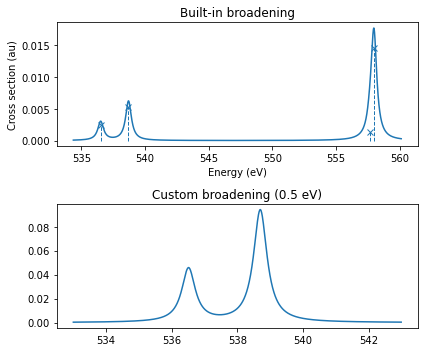

In [13]:
# Print information on eigenstates
print(adc_res.describe())

plt.figure(figsize=(6,5))
# Convolute using functionalities available in gator and adcc
plt.subplot(211); plt.title('Built-in broadening')
adc_res.plot_spectrum()

# Convoluted using information on excitation energies and oscillator strengths
plt.subplot(212); plt.title('Custom broadening (0.5 eV)')
x,y  = au2ev*adc_res.excitation_energy, adc_res.oscillator_strength
xi,yi = lorentzian(x,y,533,543,0.01,0.5); plt.plot(xi,yi)
plt.tight_layout(); plt.show()

The built-in functionality uses a small default broadening and plots the full region which is resolved, while we might want to focus on lower-energy and larger broadenings (as done in the lower panel). We note that high-energy features can often be a result of a discretized continuum region, as seen by the unphysically intense feature at $\sim$558 eV. A larger basis set will flatten out this region, but care should be taken for any analysis of that part of the spectrum.

Increasing the basis set to aug-cc-pCVTZ/cc-pVTZ (for oxygen and hydrogen, respectively), we obtain results in good agreement with [experiment](https://doi.org/10.1103/PhysRevA.47.1136):


```{figure} ../img/xray/adc_water_xas.svg
---
name: adc_water_xas
---
CVS-ADC(2)-x calculation of the oxygen X-ray absorption spectrum of gaseous water, as compared to experiment. Theoretical spectra has been shifted by 0.37 eV (to account for relativistic effects) and broadened by 0.4 eV.
```

### Spectra from TDDFT eigenstates

```{note}
To be added.
```

### Spectra from CPP-DFT

With the complex polarization propagator (CPP), also called the damped linear response function, the absorption and dispersion spectrum can be evaluated at arbitrary energies {cite}`cpp1`. With this, the X-ray absorption spectrum can then be directly calculated. For this, we need to decide on which energy/frequency region to use, which can be estimated by, *e.g.*

- Screen extended energy regions with large step size. This could potentially be done using a smaller basis set.

- With a method lacking relaxation: start the region a few eV below the IE from Koopmans' theorem. This will not work for methods capable of including relaxation, where IE:s from $\Delta$SCF could instead be considered as a first rough estimate (noting that it will work better or worse for different levels of, e.g., ADC theory).

Choosing an energy region of 514-525 eV, using a step length of 0.1 eV and a damping factor of 0.3 eV, we calculate the CPP-DFT (with the B3LYP functional) water spectrum as:

```python
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and calculation
scf_drv = vlx.ScfRestrictedDriver(comm, ostream=silent_ostream)
scf_settings = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp'}
scf_drv.update_settings(scf_settings, method_settings)
scf_drv.compute(molecule, basis)

# Define spectrum region to be resolved
freqs = np.arange(515.0,525.0,0.1)/au2ev
freqs_str = [str(x) for x in freqs]

# Calculate the response
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.3/au2ev},method_settings)
cpp_prop.init_driver(comm, ostream=silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)

# Extract the imaginary part of the complex response function and convert to absorption cross section
sigma = []
for w in freqs:
    axx = - cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = - cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = - cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0
    sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)
```

Resulting spectra can be plotted as raw, or splined for smoother figures:


```python
# Make figure with panels of 3:1 width
plt.figure(figsize=(9,5))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1]) 

# Raw results for the full region
plt.subplot(gs[0])
plt.plot(au2ev*freqs,sigma,'bx-')

# Raw results for a zoomed in region
plt.subplot(gs[1])
plt.plot(au2ev*freqs,sigma,'bx-')
plt.xlim((519.5,520.5)); plt.ylim((0,0.10))

# Raw and splined spectra for the full region
plt.subplot(gs[2])
plt.plot(au2ev*freqs,sigma,'bx')
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y = interp1d(au2ev*freqs, sigma, kind='cubic')
plt.plot(x,y(x),'r')
plt.legend(('Raw','Splined'))

# Zoomed in raw and splined spectra for the full region
plt.subplot(gs[3])
plt.plot(au2ev*freqs,sigma,'bx')
plt.plot(x,y(x),'r')
plt.xlim((519.5,520.5)); plt.ylim((0,0.10))
plt.show()
```


```{figure} ../img/xray/cpp_dft.svg
---
name: xray_cpp_dft
---
```

Increasing the basis set size and comparing to [experiment] we get:


```{figure} ../img/xray/dft_water_xas.svg
---
name: dft_water_xas
---
CPP-DFT (B3LYP) X-ray absorption spectrum of water, as compared to experiment. Theoretical spectra shifted by 14.5 eV and broadened by 0.4 eV.
```

```{note} 
Change above results to aug-cc-pCVTZ/cc-pVTZ.
```

As can be seen, the absolute excitation energies are significantly of, with a shift of 14.5 eV required to yield an approximate alignment to experiment. Part of this shift is due to lack of relativistic effects (~0.37 eV), and a small discrepancy can be expected due to the use of a limited basis set, but the main part of the error is due to two different effects:

1. Lack of [relaxation](sec:xray_topics_relax), which yield a final state too high in energy and thus shift theoretical spectra upwards in energy.

2. The [self-interaction error](sec:xray_topics_sie), which yield an erroneous self-repulsion of the dense core orbitals, and results in too low core-excitation energies.

For B3LYP the final effect of these two errors results in too low transition energies, meaning that the SIE dominates. By changing the amount of HF exchange this balance will shift and the error eventually becomes positive.

Nevertheless, the obtained CPP-DFT spectrum is in reasonable agreement with experiment once it has been shifted.


### Other approaches

Alternative methods of considering XAS include, among others:

- STEX

- TP-DFT

- RAS

- NOCIS

- ...

(sec:xray_calc_xes)=
## X-ray emission spectroscopy

Following the creating of a core-hole, the system will rapidly ($\sim$fs) decay to a valence-hole or valence-excited state, depending on whether the system is core-ionized or core-excited. These two different intermediate states  are probed when the X-ray pulse is in resonance (excited regime) or not (ionized regime), yieldig resonant/non-resonant X-ray emission spectroscopy. This section will focus on the latter, with the former following in the next section.

In the decay process the system gain large amounts of energy which need to be discarded, as can occur by emission of high-energy photon (fluorescence) or high-lying electron (Auger), with relative probability depending on edge and element. For the *K*-edge the relative probabilities are:

```{figure} ../img/xray/auger_vs_fluorescent.png
---
name: auger_vs_fluorescent
---
Fluorescence and Auger electron yields as a function of atomic number for *K*-edge core-holes. Figure taken from wikipedia.org, as [published](https://commons.wikimedia.org/wiki/File:Auger_xray_wiki_in_png_format.png) under CC BY-SA 4.0.
```

Auger decay thus dominates for light elements, which has impact on both our ability of obtaining well-resolved spectra for these elements, as well as the impact of X-ray damage on biological matter.

In non-resonant XES we measure the fluorescent decay of core-ionized states, through which we probe the (element-specific) nature of the local chemical environment. For light elements the valence space is probed directly, but for heavier elements we obtain a number of different decay channels from the valence region and the outer core region. These lines vary considerably in energy, intensity, and information content {cite}`guideXray2016`:

1. The $2p \rightarrow 1s$ ($K\alpha_1$ and $K\alpha_2$) is the most intense (due to the large overlap) and of lowest energy, and is relatively insensitive to the valence region

2. The $3p \rightarrow 1s$ ($K\beta ' $ and $K\beta_{1,3}$) is about an order of magnitude weaker and of higher energy, but more sensitive to the environment

3. Transitions from the ligand MO:s ($K\beta '' $ and $K\beta_{2,5}$), or valence-to-core (VtC), is the weakest, high-energy features which is most sensitive to the local environment


This tutorial focus on spectra of light elements, as modelled by (TD)DFT and ADC. A good starting point for learning about such modeling can be found in {cite}`coretddft2010, adcxes2019, dftXray2021`.



### Spectra from ADC

One approach for considering X-ray emission spectra is to converge the core-hole state and use this core-ionized system as the reference state for a normal excited state calculation {cite}`coretddft2010, adcxes2019`. The core-decay transitions are then the first negative eigenstates of the system, such that a standard Davidson calculation can be run on top.

Considering water with ADC(2), the oxygen X-ray emission spectrum is calculated as:

In [14]:
# Create pyscf mol object
mol = gto.Mole()
mol.atom = water_xyz
mol.basis = '6-31G'
mol.build()

# Perform unrestricted SCF calculation
scf_res = scf.UHF(mol)
scf_res.kernel()

# Copy molecular orbitals
mo0 = copy.deepcopy(scf_res.mo_coeff)
occ0 = copy.deepcopy(scf_res.mo_occ)

# Create 1s core-hole by setting alpha_0 population to zero
occ0[0][0] = 0.0

# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# Perform ADC calculation of first four states
adc_xes = adcc.adc2(scf_ion, n_states = 4)

converged SCF energy = -75.9838703827192  <S^2> = 6.3398176e-12  2S+1 = 1
converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387
Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8       0.77768   1.7s  [-19.29082067 -19.19940205 -18.96181907 -18.3637012 ]
  2    16     0.0010764  136ms  [-19.44427093 -19.36689642 -19.16826546 -18.57947501]
  3    24    4.4301e-07  189ms  [-19.44429764 -19.3669284  -19.16831914 -18.57954987]
=== Converged ===
    Number of matrix applies:    24
    Total solver time:             2s  42ms


```{note}
There will be convergence issues if including transitions from very different types, *e.g.* resolving transitions into the core and out to the unoccupied valence region simultaneously. As such, the number of required states should not be too high.
```

The resuls can be printed as a table, and convoluted and plotted using built-in functionalities or a custom broadening. Note that the eigenvalues are negative, and a sign change is thus appropriate when constructing the spectra.

+--------------------------------------------------------------+
| adc2                                        any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      -19.4443     -529.1063   0.0568    0.9548    0.0452  |
|  1     -19.36693      -527.001   0.0458    0.9503   0.04966  |
|  2     -19.16832     -521.5965   0.0419    0.9376   0.06245  |
|  3     -18.57955     -505.5753   0.0031    0.9335   0.06655  |
+--------------------------------------------------------------+



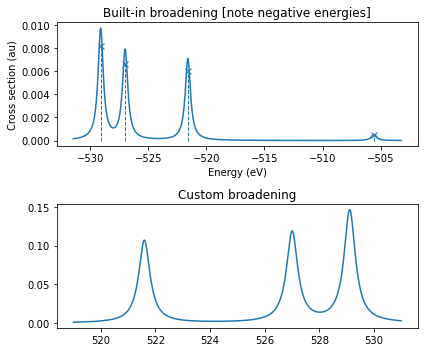

In [15]:
# Print information on eigenstates
print(adc_xes.describe())

plt.figure(figsize=(6,5))
# Convolute using functionalities available in gator and adcc
plt.subplot(211); plt.title('Built-in broadening [note negative energies]')
adc_xes.plot_spectrum()

# Convoluted using information on excitation energies and oscillator strengths
plt.subplot(212); plt.title('Custom broadening')
x,y = -au2ev*adc_xes.excitation_energy, adc_xes.oscillator_strength
xi,yi = lorentzian(x,y,519,531,0.01,0.5); plt.plot(xi,yi)
plt.tight_layout(); plt.show()

Using cc-pCVTZ/cc-pVTZ and comparing to experiment {cite}`gaswaterrixs2012`:

```{figure} ../img/xray/adc_water_xes.svg
---
name: adc_water_xes
---
ADC(2) water X-ray emission spectrum, as compared to experiment. Theoretical spectra shifted by 0.37 eV (to account for relativistic effects) and broadened by 0.3 eV.
```

While the broadening between the different lines is noticably different, it is clear that the energy spacing and integrated intensities of the features are in good agreement with experiment. Note that the theoretical spectrum is obtained at the ADC(2) level of theory, which has been to be in better agreement than ADC(2)-x and ADC(3/2) for XES {cite}`adcxes2019`.


### Spectra from TDDFT

```{note}
To be added.
```

### Spectra from ground state MO:s

While we have previously seen that Koopmans' theorem is in significant disagreement with experimental ionization energies (due to lack of relaxation), it has been noted that the *relative* position of the (valence) MO energies can still be quite reasonable. As such, a computationally very simple approach for modeling X-ray emission spectra has been used, in which transition energies are estimated from

\begin{equation}
\Delta E = \epsilon_v - \epsilon_c
\end{equation}

*i.e.* the difference in ground state MO energies. The intensities are taken to be proportional to the dipole moment:

\begin{equation}
f \propto \left| \langle \phi_i \left| \hat{\mu} \right| \phi_c \rangle \right| ^2
\end{equation}

This method is very attractive in its simplicity, requiring only a single ground state calculation and the construction of some transition dipole moments for a full spectrum calculation. However, the absolute energies are significantly off, and any differences in relaxation between the different channels will not be included.

Nevertheless, this approach has been noted to yield good (relative) agreement to experimental measurements {cite}`dftXray2021`, and it is capable of considering even massive molecular systems.

The calculation of an emission spectra requires the calculation of the ground state wave function and all relevant transition dipole moments:

In [16]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and calculation
scf_drv = vlx.ScfRestrictedDriver(comm, ostream=silent_ostream)
scf_settings = {'conv_thresh': 1.0e-6}
method_settings  = {'xcfun': 'b3lyp'}
scf_drv.update_settings(scf_settings, method_settings)
scf_drv.compute(molecule, basis)

# Extract orbital energies and number of occupied MOs
orbital_energies = scf_drv.scf_tensors['E']
nocc = molecule.number_of_alpha_electrons()
print('Occupied MO energies:',au2ev*orbital_energies[:nocc])

# Define probed core MO and calculate energy differences
n_core = 0
energy_diff = []
for n_mo in np.arange(nocc):
    if n_mo != n_core:
        energy_diff.append(au2ev*(orbital_energies[n_mo]-orbital_energies[n_core]))

# Extract MO coefficients
mo_C = scf_drv.scf_tensors['C']
         
# Load drivers for transition dipole moment
dipole_drv = vlx.ElectricDipoleIntegralsDriver(comm)

# Calculated transition dipole moments and convert to MO basis
dipole_matrices = dipole_drv.compute(molecule, basis)
x_ao = dipole_matrices.x_to_numpy(); x_mo = np.matmul(mo_C.T, np.matmul(x_ao, mo_C))
y_ao = dipole_matrices.y_to_numpy(); y_mo = np.matmul(mo_C.T, np.matmul(y_ao, mo_C))
z_ao = dipole_matrices.z_to_numpy(); z_mo = np.matmul(mo_C.T, np.matmul(z_ao, mo_C))

# Construct oscillator strengths
xx,yy,zz,sigma = [],[],[],[]
for n_mo in np.arange(nocc):
    if n_mo != n_core:
        x_tmp,y_tmp,z_tmp = x_mo[n_core,n_mo],y_mo[n_core,n_mo],z_mo[n_core,n_mo]
        xx.append(x_tmp); yy.append(y_tmp); zz.append(z_tmp)
        sigma.append(x_tmp**2+y_tmp**2+z_tmp**2)

Occupied MO energies: [-520.65710169  -27.68789316  -14.39952914   -9.70377585   -7.94953008]


The resuls can be printed as a table, and convoluted and plotted using a custom broadening. We here focus on the high-energy for the latter:

Energy   Osc. str.   x-component   y-component   z-component
492.969   0.00022      0.00000      -0.00000      -0.01478
506.258   0.00238      0.04878      -0.00000       0.00000
510.953   0.00255     -0.00000      -0.00000       0.05050
512.708   0.00342      0.00000       0.05848       0.00000


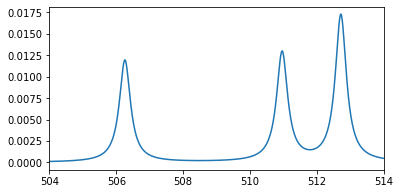

In [22]:
# Print results as a table
print('Energy   Osc. str.   x-component   y-component   z-component')
for i in np.arange(len(energy_diff)):
    e,os,x,y,z = energy_diff[i],sigma[i],xx[i],yy[i],zz[i]
    print('{:.3f}  {:8.5f}     {:8.5f}      {:8.5f}      {:8.5f}'.format(e,os,x,y,z))

# Plot X-ray emission spectrum
plt.figure(figsize=(6,3))
x,y   = energy_diff,sigma
xi,yi = lorentzian(x,y,min(x)-5,max(x)+5,0.01,0.4)
plt.plot(xi,yi)
plt.xlim((504,514))
plt.show()

Using a cc-pCVTZ/cc-pVTZ basis set and comparing to experiment {cite}`gaswaterrixs2012`:


```{figure} ../img/xray/overlap_water_xes.svg
---
name: /overlap_water_xes
---
DFT (B3LYP) overlap X-ray emission spectrum of water, as compared to experiment. Theoretical spectra shifted to approximately align the high-energy feature, and broadened by 0.3 eV.
```

The resulting spectrum is very much off in energy, but the relative agreement to experiment is quite impressive.


### Other approaches

Alternative methods of considering XES include, among others:

- CC

- ...

(sec:xray_calc_rixs)=
## Resonant inelastic X-ray scattering

We here focus on the electronic part of the RIXS plane. Can also go close to the Rayleigh line, which probe local vibrational modes.


### Two-step approach with ADC

An approximate treatment of the RIXS plane can be achieved by considering it as a two-step process {cite}`adcwaterrixs2018`, with:

1. A core-excitation as modeled like a normal X-ray absorption spectrum

2. A core-decay process from the core-hole system with an electron put in each relevant final state probed in (1), modeled as a (non-resonant) X-ray emission spectrum

```{note}
Insert discussion of spin-contamination, as LSOR yield $\langle S^2 \rangle = 1$.
```

The RIXS plane is then constructed from above absorption and emission energies, with RIXS intensity from the multiplication of respective oscillator strength.

Note that this approach is an approximation, as it disregards potentially important detuning effects, and in the example given below we also ignore existing coupling between the polarization in the incoming and outgoing photon. Furthermore, it requires the convergence of core-ionized states, which is much trickier than core-ionized, and will likely only work for the first few core-excited states.

Nevertheless, the scheme is quite easy to understand, and introducing core-excited dynamics is relatively straightforward. As such, we here illustrate how the RIXS plane of water can be constructed.

```python
# Create pyscf mol object
mol = gto.Mole()
mol.atom = water_xyz
mol.basis = '6-31G'
mol.build()

# Perform restricted SCF calculation
scf_gs = scf.RHF(mol)
scf_gs.kernel()

# Calculate X-ray absorption spectrum
adc_xas = adcc.cvs_adc2(scf_gs, n_singlets=4, core_orbitals=1)
print(adc_xas.describe())

# Perform unrestricted SCF calculation
scf_gs = scf.UHF(mol)
scf_gs.kernel()

# Calculate resonant X-ray emission spectrum
#   for states where the core-electron is moved to LUMO or LUMO+1
adc_rxes = []
for n in [5,6]:
    # Copy molecular orbitals
    mo0  = copy.deepcopy(scf_gs.mo_coeff)
    occ0 = copy.deepcopy(scf_gs.mo_occ)
    # Move 1s electron to LUMO / LUMO+1
    occ0[0][0] = 0.0
    occ0[0][n] = 1.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    # Calculate resonant X-ray emission spectrum
    adc_rxes.append(adcc.adc2(scf_ion, n_states=4))
```

Now the correct combinations of transition energies and intensities need to be calculated:

```python
adc_rixs = []

# Probing LUMO and LUMO+1
for indx in [0,1]:
    # From XAS calculation
    E_xas = au2ev*adc_xas.excitation_energy[indx]
    I_xas = adc_xas.oscillator_strength[indx]
    # From XES calculation
    for i in np.arange(len(adc_rxes[indx])):
        E_xes = -au2ev*adc_rxes[indx].excitation_energy[i]
        I_xes = adc_rxes[indx].oscillator_strength[i]
        adc_rixs.append([E_xas, E_xes, I_xas*I_xes])
```

And the RIXS plane can then be constructed:

```python
plt.figure(figsize=(8,6))
# Plot absorption spectrum
plt.subplot(222)
x,y   = au2ev*adc_xas.excitation_energy, adc_xas.oscillator_strength
xi,yi = lorentzian(x,y,min(x)-2,min(x)+5,0.01,0.3)
plt.plot(yi,xi)

# Plot emission specta, with vertical shift from absorbed energy
plt.subplot(223)
# LUMO
x,y   = -au2ev*adc_rxes[0].excitation_energy, adc_rxes[0].oscillator_strength
xi,yi = lorentzian(x,5.*y,x[1]-9,x[1]+2,0.01,0.3)
plt.plot(xi,yi+au2ev*adc_xas.excitation_energy[0])
# LUMO+1
x,y   = -au2ev*adc_rxes[0].excitation_energy, adc_rxes[1].oscillator_strength
xi,yi = lorentzian(x,5.*y,x[1]-9,x[1]+2,0.01,0.3)
plt.plot(xi,yi+au2ev*adc_xas.excitation_energy[1])

# Plot RIXS plane, here with marker size scaling with intensity
plt.subplot(221)
for i in np.arange(len(adc_rixs)):
    tmp = adc_rixs[i]
    plt.plot(tmp[1],tmp[0],'ok',markersize=10000*tmp[2])
    
# Zooming in to region spanned by XAS and XES projections
plt.xlim((519,530))
plt.ylim((536,544))
    
plt.tight_layout(); plt.show()
```


```{figure} ../img/xray/adc_2st_rixs.svg
---
name: adc_2st_rixs
---
```

### Two-step approach with TDDFT

```{note}
To be added.
```


### Dirac-Kramer-Heisenberg with ADC

```{note}
To be added.
```

### HERFD

```{note}
Discuss briefly - could add illustration.
```


### Other approaches

Alternative methods of considering RIXS include, among others:

- ...